# Zipline Coding Exercises

In this notebook you will create your own pipeline and create custom factors and filters for it. 

### Install Packages

In [9]:
# import sys
# !{sys.executable} -m pip install -r requirements.txt

# Load Data

In [11]:
import os

from zipline.data import bundles
from zipline.data.bundles.csvdir import csvdir_equities


# Specify the bundle name
bundle_name = 'm4-quiz-eod-quotemedia'

# Create an ingest function 
ingest_func = csvdir_equities(['daily'], bundle_name)

# Register the data bundle and its ingest function
bundles.register(bundle_name, ingest_func);

# Set environment variable 'ZIPLINE_ROOT' to the path where the most recent data is located
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..', 'data', 'module_4_quizzes_eod')

# Load the data bundle
bundle_data = bundles.load(bundle_name)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Overwriting bundle with name 'm4-quiz-eod-quotemedia'
  


# Build an Empty Pipeline with a Screen

In the code below create an empty with a screen that filters the pipeline output for stocks with a 60-day average dollar volume greater than \$50,000.

In [3]:
# import resources
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume


# Create a screen for our Pipeline
universe = (AverageDollarVolume(window_length=60) > 50000)

# Create an empty Pipeline with the given screen
pipeline = Pipeline(screen = universe)

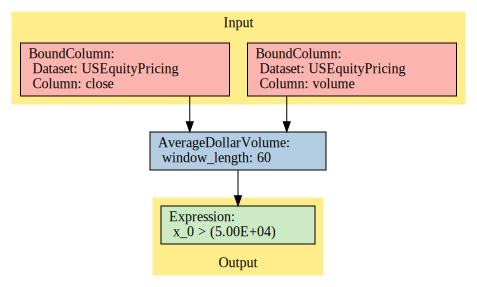

In [4]:
import graphviz

# show our pipeline as a graph
pipeline.show_graph()

# Create a Pipeline Engine

In the code below, create a data loader that loads our data bundle using Zipline's `USEquityPricingLoader`. Then create a function to be passed to the `get_loader` parameter in the pipeline engine. Using the NYSE trading calendar create a pipeline engine using Zipline's `SimplePipelineEngine`

In [5]:
# import resources
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.utils.calendars import get_calendar
from zipline.pipeline.engine import SimplePipelineEngine

# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader)


# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# Set the trading calendar
trading_calendar = get_calendar('NYSE')

# Create a Pipeline engine
engine = SimplePipelineEngine(get_loader = choose_loader,
                             calendar = trading_calendar.all_sessions, 
                             asset_finder = bundle_data.asset_finder)

#  Create Factors and Filters For The Pipeline

### Factors

In the code below, create two factors:

1. **Custom Factor**: Create a custom factor, `percent_difference`,  by combining a 30-day average closing price factor and a 60-average closing price factor. The `percent_difference` factor will calculate the difference between the 30-day and 60-average closing price factors, and will then normalize this difference by the 60-average closing price factor.


2. **Daily Returns Factor**: Create a factor that returns the daily percent change in closing price. To do this, use Zipline's built-in [DailyReturns](https://www.zipline.io/appendix.html#zipline.pipeline.factors.DailyReturns) factor.

Both factors should use the closing prices in the `USEquityPricing`  dataset as inputs. 




### Filters

In the code below, you will create a **Custom Filter**, `tradable_asset`, that returns `True` for the top 20 securities of average dollar volume in a 30 day-window that have a latest closing price above \$30. To do this, you will create two filters first and them combine them. For the first filter, you can use Zipline's built-in factor `AverageDollarVolume()` and its method `.top()` to select the top 20 assets of average dollar volume in a 30 day-window. To get the latest close price of the `USEquityPricing` dataset you can use `USEquityPricing.close.latest`. Finally you can combine these two filters by using the logical operator `&`. 

In [6]:
# import resources
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import DailyReturns


# Create the 30-day average closing price factor
mean_close_30 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=30)

# Create the 60-day average closing price factor
mean_close_60 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=60)

# Create the custom factor
percent_difference = (mean_close_30 - mean_close_60)/mean_close_60 

# Create the daily returns factor
daily_returns = DailyReturns()

# Create a filter for the top 20 securities of average dollar volume in a 30 day-window
top_20_m_c_30 = AverageDollarVolume(window_length=30).top(20)

# Create a filter for the latest closing price above $30
close_more_30 = USEquityPricing.close.latest > 30

# Create a custom filter
custom_filter = top_20_m_c_30 & close_more_30

# Add Factors and Filters To The Pipeline

In the code below, add the factors and filters you created above to the pipeline

In [7]:
# Add the custom factor to the pipeline
pipeline.add(percent_difference, 'Percent diff 30-60 MA')


# Add the daily returns factor to the pipeline
pipeline.add(daily_returns, 'Daily Returns')

# Add the custom filter to the pipeline
pipeline.add(custom_filter, 'Top 20 Vol & close above 29')

# Run The Pipeline

In the code below, run the pipeline for the dates given

In [8]:
# Set starting and end dates
start_date = pd.Timestamp('2014-01-06', tz='utc')
end_date = pd.Timestamp('2016-01-05', tz='utc')

# Run our pipeline for the given start and end dates
output = engine.run_pipeline(pipeline, start_date, end_date)


# Display the pipeline output
display(output.head())
display(output.tail())

Daily Returns  \
2014-01-06 00:00:00+00:00 Equity(0 [A])          0.006951   
                          Equity(1 [AAL])        0.046523   
                          Equity(2 [AAP])        0.028611   
                          Equity(3 [AAPL])      -0.021972   
                          Equity(4 [ABBV])       0.006147   

                                            Percent diff 30-60 MA  \
2014-01-06 00:00:00+00:00 Equity(0 [A])                  0.025939   
                          Equity(1 [AAL])                0.055887   
                          Equity(2 [AAP])                0.051009   
                          Equity(3 [AAPL])               0.035906   
                          Equity(4 [ABBV])               0.033018   

                                            Top 20 Vol & close above 29  
2014-01-06 00:00:00+00:00 Equity(0 [A])                           False  
                          Equity(1 [AAL])                         False  
                          Equity(2 [AAP])                         False  
                          Equity(3 [AAPL])                         True  
                          Equity(4 [ABBV])                        False

Daily Returns  \
2016-01-05 00:00:00+00:00 Equity(486 [XYL])       -0.011520   
                          Equity(487 [YUM])       -0.011489   
                          Equity(488 [ZBH])       -0.007604   
                          Equity(489 [ZION])      -0.021614   
                          Equity(490 [ZTS])       -0.013564   

                                              Percent diff 30-60 MA  \
2016-01-05 00:00:00+00:00 Equity(486 [XYL])                0.015590   
                          Equity(487 [YUM])                0.017369   
                          Equity(488 [ZBH])                0.000997   
                          Equity(489 [ZION])              -0.009076   
                          Equity(490 [ZTS])                0.032504   

                                              Top 20 Vol & close above 29  
2016-01-05 00:00:00+00:00 Equity(486 [XYL])                         False  
                          Equity(487 [YUM])                         False  
                          Equity(488 [ZBH])                         False  
                          Equity(489 [ZION])                        False  
                          Equity(490 [ZTS])                         False